In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

%matplotlib inline

import os, sys,glob, copy
sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code")

import data_loader as dl
reload(dl)

from scipy.ndimage import gaussian_filter

/Users/xiaoxuanj/anaconda/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/Users/xiaoxuanj/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/xiaoxuanj/anaconda/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/xiaoxuanj/anaconda/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/Users/xiaoxuanj/anaconda/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtyp

In [2]:
import numpy as np
from scipy import stats
import scipy

def xcorrfft(a,b,NFFT):
    # first dimention of a should be length of time
    CCG = np.fft.fftshift(np.fft.ifft(np.multiply(np.fft.fft(a,NFFT), np.conj(np.fft.fft(b,NFFT)))))
    return CCG

def nextpow2(n):
    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i


def jitter(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """Jitter correction adapted from Amin. Used in several neuron papers.
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial*ori
       l: time window
    """
    if len(np.shape(data))>3:
        flag = 1
        sd = np.shape(data)
        data = np.reshape(data,(np.shape(data)[0],np.shape(data)[1],len(data.flatten())/(np.shape(data)[0]*np.shape(data)[1])), order='F')
    else:
        flag = 0

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if np.shape(psth)[1]>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
    else:
        dataj = np.squeeze(np.sum(np.reshape(data,l,np.shape(data)[0]//l,np.shape(data)[1], order='F')))
        psthj = np.sum(np.reshape(psth,l,np.shape(psth)[0]//l, order='F'))


    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');

    psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
    psthj[psthj==0] = 10e-10

    corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
    corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
    corr = np.tile(corr,[l, 1, 1, 1])
    corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');

    psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
    output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr

    output = output[:length,:,:]
    return output

def jitter_1d(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """Jitter correction adapted from Amin. Used in several neuron papers.
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial
       l: time window
    """

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if len(np.shape(psth))>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
        corr = np.tile(corr,[l, 1, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr
        output = output[:length,:,:]
        
    elif len(np.shape(psth))==1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1]], order='F'), axis=0))
        psthj = np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l], order='F'), axis=0)
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1]])
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1]], order='F')
        corr = np.tile(corr,[l, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1]])*corr
        output = output[:length,:]
        
    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');
        
    return output

In [15]:
mouseID = 'mouse388523'
spikes = dl.load_npz('/Users/xiaoxuanj/work/work_allen/Ephys/'+mouseID+'/matrix/drifting_grating_cortex_rep.npz')

In [16]:
spikes.shape

(559, 4, 2, 2, 100, 2010)

In [17]:
spikes = spikes.reshape(spikes.shape[0], 16, 100, 2010)

In [18]:
spikes = spikes[:,:,:,:2000]

In [19]:
df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/'+mouseID+'/matrix/'+mouseID+'_cortex_meta.csv')

In [20]:
len(df)

559

In [21]:
FR = df.FR

In [30]:
FR_index=np.where(FR>20)[0]

In [31]:
len(FR_index)

19

In [32]:
window=500
jitterwindow=25
n_unit=np.shape(spikes)[0]
n_t = np.shape(spikes)[3]
# triangle function
t = np.arange(-(n_t-1),(n_t-1))
theta = n_t-np.abs(t)
del t
NFFT = int(nextpow2(2*n_t))
target = np.array([int(i) for i in NFFT/2+np.arange((-n_t+2),n_t)])

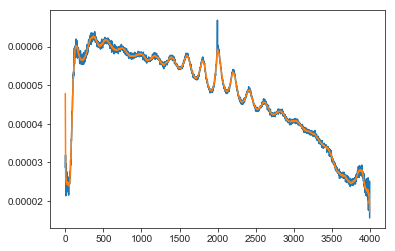

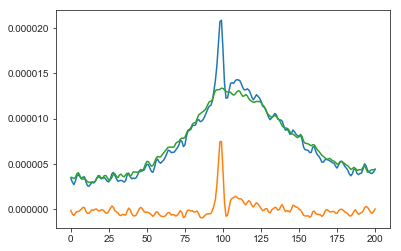

In [39]:
# input shape is neuron*ori*rep*time
i=0
j=2

temp1 = np.squeeze(spikes[FR_index[i],:,:,:])
temp2 = np.squeeze(spikes[FR_index[j],:,:,:])

FR1 = np.squeeze(np.mean(np.sum(temp1,axis=2), axis=1))/np.shape(spikes)[3]*1000
FR2 = np.squeeze(np.mean(np.sum(temp2,axis=2), axis=1))/np.shape(spikes)[3]*1000

tempccg = xcorrfft(temp1,temp2,NFFT)
tempccg = np.squeeze(np.nanmean(tempccg[:,:,target],axis=1))

tempshift = xcorrfft(temp1[:,:-1,:],temp2[:,1:,:],NFFT)
tempshift = np.squeeze(np.nanmean(tempshift[:,:,target],axis=1))

triangle = np.multiply(np.tile(np.sqrt(FR1*FR2), (len(target), 1)), np.tile(theta.T.reshape(len(theta),1),(1,len(FR1))))
ccgshuffle=np.divide((tempccg - tempshift).T, np.squeeze(triangle))


temp1 = np.rollaxis(np.rollaxis(temp1,2,0), 2,1)
temp2 = np.rollaxis(np.rollaxis(temp2,2,0), 2,1)
# input shape is time*neuron*ori*rep
ttemp1 = jitter(temp1,jitterwindow);  
ttemp2 = jitter(temp2,jitterwindow);
# temp format: [ori, rep, time]
tempjitter = xcorrfft(np.rollaxis(np.rollaxis(ttemp1,2,0), 2,1),np.rollaxis(np.rollaxis(ttemp2,2,0), 2,1),NFFT);  
tempjitter = np.squeeze(np.nanmean(tempjitter[:,:,target],axis=1))

ccgjitter=np.divide((tempccg - tempjitter).T, np.squeeze(triangle))

plt.figure()
plt.plot(gaussian_filter(np.real(np.nanmean(np.divide(tempccg.T, np.squeeze(triangle)), axis=1)),1))
plt.plot(gaussian_filter(np.real(np.nanmean(np.divide(tempjitter.T, np.squeeze(triangle)), axis=1)),1))

plt.figure()
winall=len(triangle)
window=100
plt.plot(gaussian_filter(np.real(np.nanmean(ccgshuffle[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.plot(gaussian_filter(np.real(np.nanmean(ccgjitter[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.plot(gaussian_filter(np.real(np.nanmean(ccgshuffle[winall//2-window:winall//2+window+1,:], axis=1))-np.real(np.nanmean(ccgjitter[winall//2-window:winall//2+window+1,:], axis=1)),1))


<Figure size 432x288 with 0 Axes>

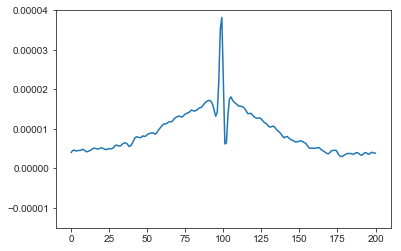

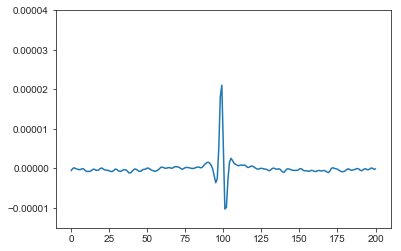

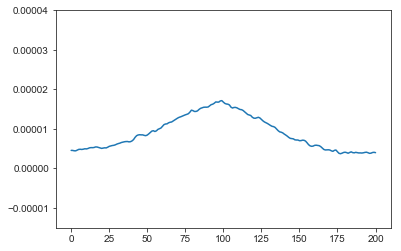

In [38]:
plt.figure()
winall=len(triangle)
window=100
plt.figure()
plt.plot(gaussian_filter(np.real(np.nanmean(ccgshuffle[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.ylim([-0.000015, 0.00004])
plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/ccg_shuffle.pdf')

plt.figure()
plt.plot(gaussian_filter(np.real(np.nanmean(ccgjitter[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.ylim([-0.000015, 0.00004])
plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/ccg_jitter.pdf')

plt.figure()
plt.plot(gaussian_filter(np.real(np.nanmean(ccgshuffle[winall//2-window:winall//2+window+1,:], axis=1))-np.real(np.nanmean(ccgjitter[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.ylim([-0.000015, 0.00004])
plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/ccg_jitter_corrected.pdf')

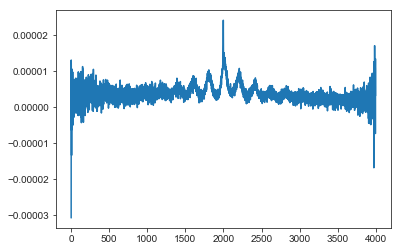

In [54]:
plt.plot(ccgshuffle.mean(1))

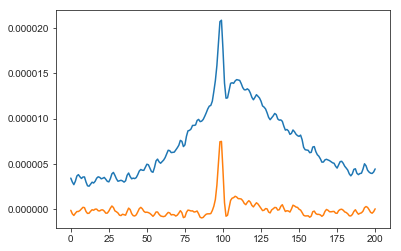

In [55]:
winall=len(triangle)
window=100
plt.plot(gaussian_filter(np.real(np.nanmean(ccgshuffle[winall//2-window:winall//2+window+1,:], axis=1)),1))
plt.plot(gaussian_filter(np.real(np.nanmean(ccgjitter[winall//2-window:winall//2+window+1,:], axis=1)),1))

# need to use nanmean to average across orientations for all pairs

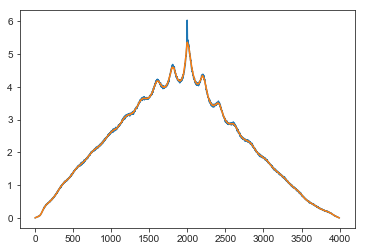

In [60]:
plt.plot(gaussian_filter(np.real(np.nanmean(tempccg[:,:], axis=0)),1))
plt.plot(gaussian_filter(np.real(np.nanmean(tempjitter[:,:], axis=0)),1))


In [45]:
window=500
jitterwindow=25
n_unit=np.shape(spikes)[0]
n_t = np.shape(spikes)[3]
# triangle function
t = np.arange(-(n_t-1),(n_t-1))
theta = n_t-np.abs(t)
del t
NFFT = int(nextpow2(2*n_t))
target = np.array([int(i) for i in NFFT/2+np.arange((-n_t+2),n_t)])


x1 = np.random.choice([0, 1], size=(n_t,), p=[1./3, 2./3])

In [46]:
x2 = x1

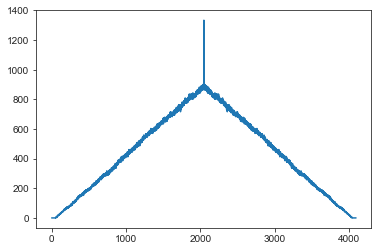

In [50]:
plt.plot(xcorrfft(x1,x2,NFFT))